In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, TensorDataset, DataLoader
from google.colab import files
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import time

To speed up processing, this notebook uses a GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Gather and prepare data

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 4.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=3c85aea8c577037378587cda4f368e248c00695746f4a32601da2ebe30509c93
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 97% 793M/814M [00:08<00:00, 75.4MB/s]
100% 814M/814M [00:09<00:00, 94.3MB/s]


In [ ]:
!mkdir data
!mkdir data/test
!unzip dogs-vs-cats-redux-kernels-edition.zip -d data
!unzip data/train.zip -d data

## Split data into training and validation sets

In [ ]:
train_dir = 'data/train/'
test_dir = 'data/test/'

train_cats_dir = train_dir + 'cats/'
train_dogs_dir = train_dir + 'dogs/'

test_cats_dir = test_dir + 'cats/'
test_dogs_dir = test_dir + 'dogs/'

### how many records
n = len(os.listdir(train_dir))
print(n)

2


In [ ]:
### to split into 80/20, first select 5k random indexes
test_idxs = random.sample(list(range(n)), int(.2* n))
train_idxs = [i for i in list(range(n)) if i not in test_idxs]
print(len(train_idxs))
print(len(test_idxs))

2
0


In [ ]:
### move test images to test folder
for i, f in enumerate(os.listdir(train_dir)):
    if i in test_idxs:
        shutil.move(train_dir + f, test_dir + f)

print(len(os.listdir(train_dir)))
print(len(os.listdir(test_dir)))

2
2


In [ ]:
!mkdir data/train/cats
!mkdir data/train/dogs
!mkdir data/test/cats
!mkdir data/test/dogs

In [ ]:
### move train files into cat/dog folders
for f in os.listdir(train_dir):
    species = f.split('.')[0]
    if 'jpg' in f:
        if species == 'dog' and 'jpg' in f: shutil.move(train_dir + f, train_dogs_dir + f)
        else: shutil.move(train_dir + f, train_cats_dir + f)

### same for test files
for f in os.listdir(test_dir):
    species = f.split('.')[0]
    if 'jpg' in f:
        if species == 'dog': shutil.move(test_dir + f, test_dogs_dir + f)
        else: shutil.move(test_dir + f, test_cats_dir + f)

Preview some training images to make sure cats/dogs are in the right folders

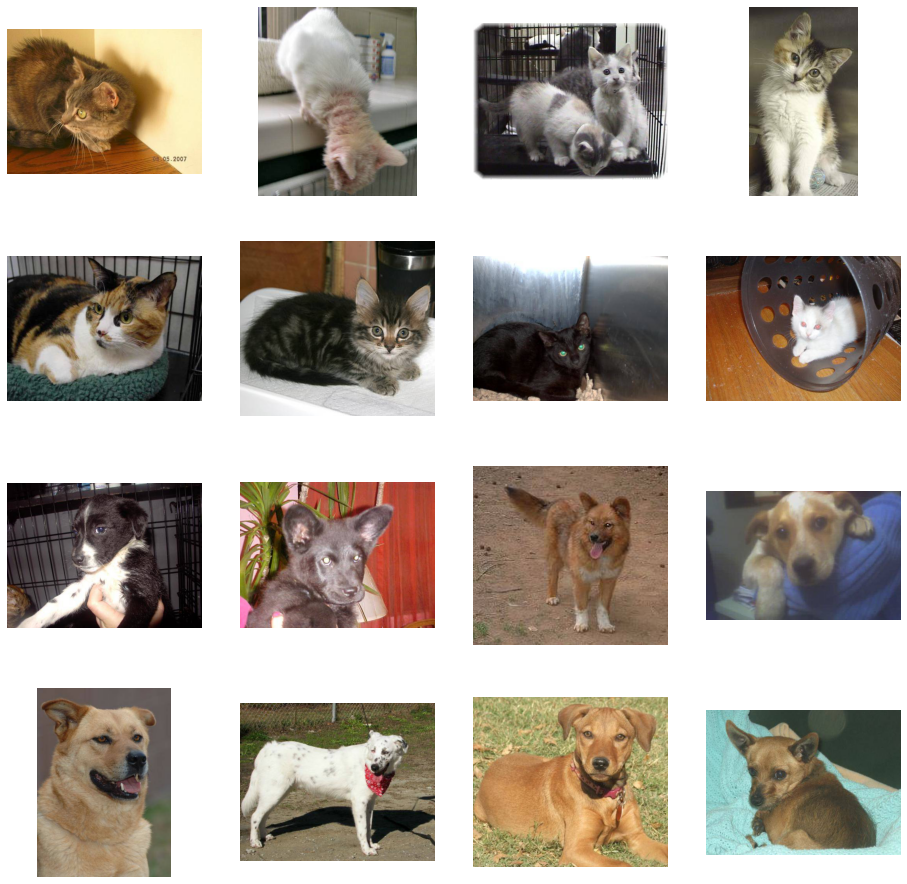

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
nrow = 4
ncol = 4

fig = plt.gcf()
fig.set_size_inches(16, 16)

sample_cat_pix = [i for i in os.listdir(train_cats_dir)][:8]
sample_dog_pix = [i for i in os.listdir(train_dogs_dir)][:8] 

for i, img_f in enumerate(sample_cat_pix + sample_dog_pix):
    if 'cat' in img_f: img_f = train_cats_dir + img_f
    else: img_f = train_dogs_dir + img_f
    sp = plt.subplot(nrow, ncol, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_f)
    plt.imshow(img)

plt.show()

Do the same for test images

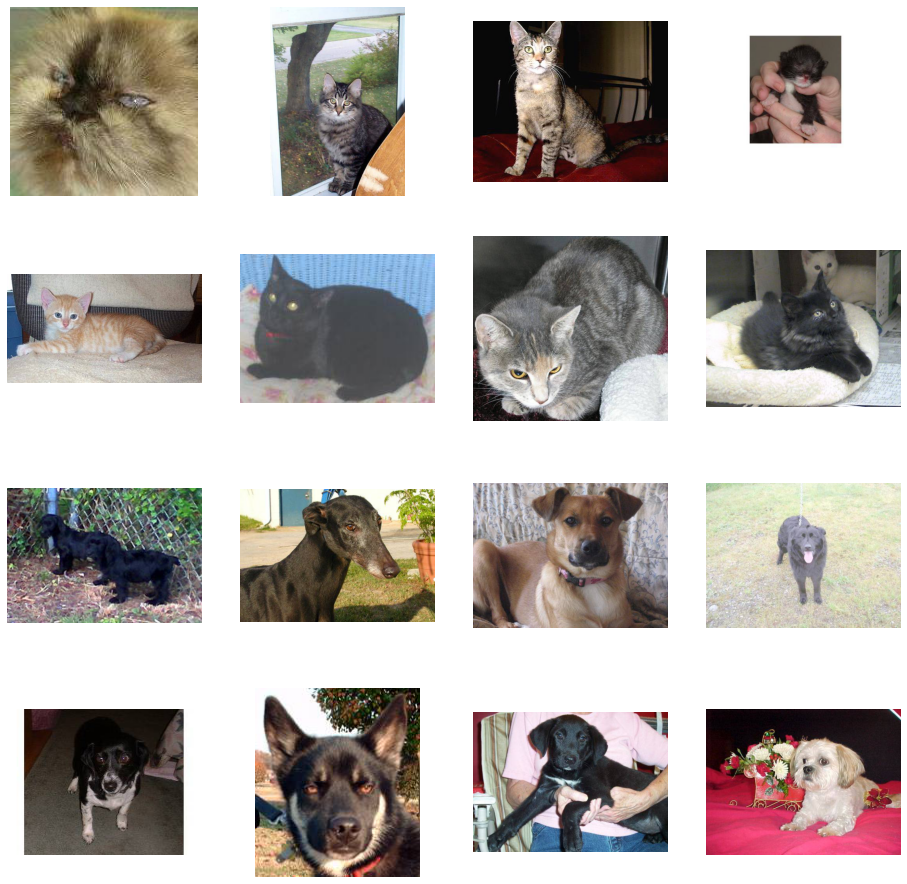

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
nrow = 4
ncol = 4

fig = plt.gcf()
fig.set_size_inches(16, 16)

sample_cat_pix = [i for i in os.listdir(test_cats_dir)][:8]
sample_dog_pix = [i for i in os.listdir(test_dogs_dir)][:8] 

for i, img_f in enumerate(sample_cat_pix + sample_dog_pix):
    if 'cat' in img_f: img_f = test_cats_dir + img_f
    else: img_f = test_dogs_dir + img_f
    sp = plt.subplot(nrow, ncol, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_f)
    plt.imshow(img)

plt.show()

# Build transformers and set up model

In [ ]:
transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = datasets.ImageFolder(train_dir, transform=transformer)

testset = datasets.ImageFolder(test_dir, transform=transformer)

### set batch size as separate param
batchsize = 32

trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                    shuffle=True, drop_last=True)

testLoader = torch.utils.data.DataLoader(testset, shuffle=False,
                                         batch_size=batchsize)

classes = ('cats', 'dogs')

## Set functions needed for early stopping

In [ ]:
### define early stopping function
def stop_early(epoch, n_epochs_stop, n_epochs_no_improve):
    val = False
    ## set min epochs
    if epoch > 5 and n_epochs_no_improve==n_epochs_stop: val = True
    return val

In [ ]:
### function to save best model (borrowed from pytorch examples github):
## https://github.com/pytorch/examples/blob/60108edfa3838a823220e16428cb5f98e8e88d53/imagenet/main.py#L353
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    shutil.copyfile(filename, 'model_best.pth.tar')

## Load AlexNet model

In [ ]:
AlexNet = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
AlexNet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [ ]:
#Updating the output layer of the network since we are only predicting 2 classes
AlexNet.classifier[6] = nn.Linear(4096, 2)

# Train model

In [ ]:
model = AlexNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
%%time
### track loss 
train_losses = []
test_losses = []
best_test_loss = 100000

epochs = 20
n_epochs_stop = 5
n_epochs_no_improve = 0

start = time.time()

for epoch in range(epochs):
    running_train_loss = 0
    model.train()
    for i, (inputs, labels) in enumerate(trainLoader):

        if i % 100 == 0: print('Epoch # {}, loop # {}'.format(epoch, i))

        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        running_train_loss += train_loss
        train_loss.backward()
        optimizer.step()

    ## save average training loss at end of epoch
    train_losses.append(running_train_loss/(i+1))

    # turn off gradients for evaluation
    with torch.no_grad():
        model.eval()
        running_test_loss = 0
        for i, (inputs, labels) in enumerate(testLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss
        
        ## save average test loss at end of epoch
        test_losses.append(running_test_loss/(i+1))

    print('Epoch #', epoch, '\ttraining loss: {}\ttesting_loss: {}'\
            .format(train_losses[-1], test_losses[-1]))
    print('Time so far:', round((time.time() - start) / 60, 2),'(in minutes)')
    
    ## save best model when training loss improves
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        ## make a checkpoint for new best model
        torch.save(model.state_dict(), 'best_model.pt')
        print('new best model')
        ### reset no_improve counter to zero
        n_epochs_no_improve = 0
    else: n_epochs_no_improve += 1
    ## for early stoping
    if stop_early(epoch, n_epochs_stop, n_epochs_no_improve):
        print('Model stopped improving for 5 consecutive epochs.')
        break

model.load_state_dict(torch.load('best_model.pt'))

Epoch # 0, loop # 0
Epoch # 0, loop # 100
Epoch # 0, loop # 200
Epoch # 0, loop # 300
Epoch # 0, loop # 400
Epoch # 0, loop # 500
Epoch # 0, loop # 600
Epoch # 0 	training loss: 0.12291073054075241	testing_loss: 0.07316111028194427
Time so far: 2.19 (in minutes)
new best model
Epoch # 1, loop # 0
Epoch # 1, loop # 100
Epoch # 1, loop # 200
Epoch # 1, loop # 300
Epoch # 1, loop # 400
Epoch # 1, loop # 500
Epoch # 1, loop # 600
Epoch # 1 	training loss: 0.07128296792507172	testing_loss: 0.06641446799039841
Time so far: 4.47 (in minutes)
new best model
Epoch # 2, loop # 0
Epoch # 2, loop # 100
Epoch # 2, loop # 200
Epoch # 2, loop # 300
Epoch # 2, loop # 400
Epoch # 2, loop # 500
Epoch # 2, loop # 600
Epoch # 2 	training loss: 0.052216075360774994	testing_loss: 0.06125874072313309
Time so far: 6.64 (in minutes)
new best model
Epoch # 3, loop # 0
Epoch # 3, loop # 100
Epoch # 3, loop # 200
Epoch # 3, loop # 300
Epoch # 3, loop # 400
Epoch # 3, loop # 500
Epoch # 3, loop # 600
Epoch # 3 	tr

# Evaluate performance

Compare loss over time between train/test images

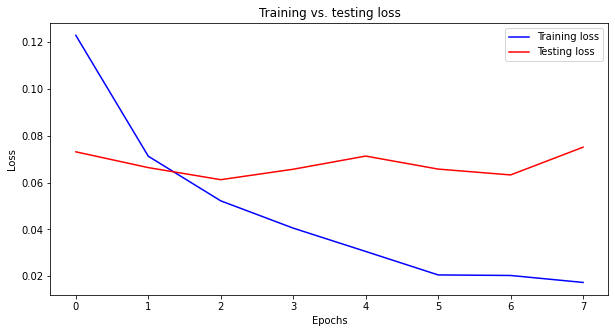

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list(range(len(train_losses))), train_losses, color='blue')
plt.plot(list(range(len(test_losses))), test_losses, color='red')
plt.title('Training vs. testing loss')
plt.legend(('Training loss', 'Testing loss'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Look at accuracy on test images

In [ ]:
correct = 0
total = 0
class_correct = [0, 0]
class_total = [0, 0]
with torch.no_grad():
    for (inputs, labels) in testLoader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted==labels).squeeze()
        correct += c.sum().item()
        total += labels.size(0)

        ### last batch isn't a full batchsize; produces error if not accounted for
        if labels.shape[0] != batchsize: samples = labels.shape[0]
        else: samples = batchsize
        for i in range(samples):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [ ]:
print('Overall accuracy: {}%\n'.format(round(100 * correct / total, 2)))

for i in range(len(classes)):
    print('Accuracy of {} : {}%'.format(
        classes[i], round(100 * class_correct[i] / class_total[i],2)))

Overall accuracy: 97.48%

Accuracy of cats : 97.08%
Accuracy of dogs : 97.89%


# Re-build the model from scratch

In [ ]:
class AlexNetHomeGrown(nn.Module):
    def __init__(self):
        super(AlexNetHomeGrown, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4,4), padding=(2,2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1),
            nn.Conv2d(64, 192, kernel_size=(5,5), stride=(1,1), padding=(2,2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1),
            nn.Conv2d(192, 384, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(6, 6)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )
    def forward(self, X):
        return self.classifier(self.features(X))

# Train model

In [ ]:
model = AlexNetHomeGrown()

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
%%time
### track loss 
train_losses = []
test_losses = []
best_test_loss = 100000

epochs = 100
n_epochs_stop = 5
n_epochs_no_improve = 0

start = time.time()

for epoch in range(epochs):
    running_train_loss = 0
    model.train()
    for i, (inputs, labels) in enumerate(trainLoader):

        if i % 100 == 0: print('Epoch # {}, loop # {}'.format(epoch, i))

        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        running_train_loss += train_loss
        train_loss.backward()
        optimizer.step()

    ## save average training loss at end of epoch
    train_losses.append(running_train_loss/(i+1))

    # turn off gradients for evaluation
    with torch.no_grad():
        model.eval()
        running_test_loss = 0
        for i, (inputs, labels) in enumerate(testLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss
        
        ## save average test loss at end of epoch
        test_losses.append(running_test_loss/(i+1))

    print('Epoch #', epoch, '\ttraining loss: {}\ttesting_loss: {}'\
            .format(train_losses[-1], test_losses[-1]))
    print('Time so far:', round((time.time() - start) / 60, 2),'(in minutes)')
    
    ## save best model when training loss improves
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        ## make a checkpoint for new best model
        torch.save(model.state_dict(), 'best_model.pt')
        print('new best model')
        ### reset no_improve counter to zero
        n_epochs_no_improve = 0
    else: n_epochs_no_improve += 1
    ## for early stoping
    if stop_early(epoch, n_epochs_stop, n_epochs_no_improve):
        print('Model stopped improving for 5 consecutive epochs.')
        break

model.load_state_dict(torch.load('best_model.pt'))

Epoch # 0, loop # 0
Epoch # 0, loop # 100
Epoch # 0, loop # 200
Epoch # 0, loop # 300
Epoch # 0, loop # 400
Epoch # 0, loop # 500
Epoch # 0, loop # 600
Epoch # 0 	training loss: 1.3550857305526733	testing_loss: 0.7145671248435974
Time so far: 2.42 (in minutes)
new best model
Epoch # 1, loop # 0
Epoch # 1, loop # 100
Epoch # 1, loop # 200
Epoch # 1, loop # 300
Epoch # 1, loop # 400
Epoch # 1, loop # 500
Epoch # 1, loop # 600
Epoch # 1 	training loss: 0.7068480849266052	testing_loss: 0.716769278049469
Time so far: 4.82 (in minutes)
Epoch # 2, loop # 0
Epoch # 2, loop # 100
Epoch # 2, loop # 200
Epoch # 2, loop # 300
Epoch # 2, loop # 400
Epoch # 2, loop # 500
Epoch # 2, loop # 600
Epoch # 2 	training loss: 0.6966158747673035	testing_loss: 0.6809797286987305
Time so far: 7.18 (in minutes)
new best model
Epoch # 3, loop # 0
Epoch # 3, loop # 100
Epoch # 3, loop # 200
Epoch # 3, loop # 300
Epoch # 3, loop # 400
Epoch # 3, loop # 500
Epoch # 3, loop # 600
Epoch # 3 	training loss: 0.66444575

# Evaluate performance

Compare loss over time between train/test images

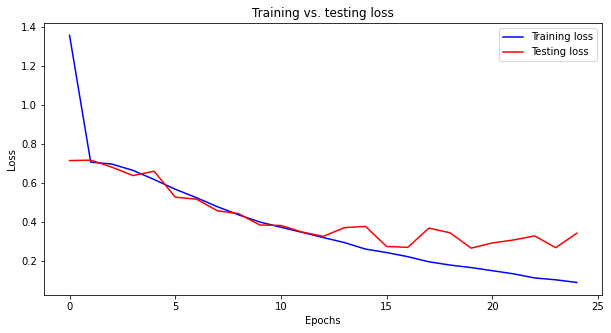

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list(range(len(train_losses))), train_losses, color='blue')
plt.plot(list(range(len(test_losses))), test_losses, color='red')
plt.title('Training vs. testing loss')
plt.legend(('Training loss', 'Testing loss'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Look at accuracy on test images

In [ ]:
correct = 0
total = 0
class_correct = [0, 0]
class_total = [0, 0]
with torch.no_grad():
    for (inputs, labels) in testLoader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted==labels).squeeze()
        correct += c.sum().item()
        total += labels.size(0)

        ### last batch isn't a full batchsize; produces error if not accounted for
        if labels.shape[0] != batchsize: samples = labels.shape[0]
        else: samples = batchsize
        for i in range(samples):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [ ]:
print('Overall accuracy: {}%\n'.format(round(100 * correct / total, 2)))

for i in range(len(classes)):
    print('Accuracy of {} : {}%'.format(
        classes[i], round(100 * class_correct[i] / class_total[i],2)))

Overall accuracy: 89.46%

Accuracy of cats : 90.19%
Accuracy of dogs : 88.74%
